In this notebook, I will try to predict the clusters based on input image data. I will also attempt to increase the accuracy through edge detection, SIFT, and other image processing techniques. Based on https://github.com/risenW/medium_tutorial_notebooks/blob/master/dogs-vs-cats-keras-implementation.ipynb

In [1]:
import cv2
import numpy as np
import pandas as pd
import math
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline 

import os
import random
import gc #Gabage collector for cleaning deleted data from memory
import itertools


The train data contains 25,000 images of both dogs and cats. We are going to sample a small portion of  the data for training because of memory and Ram limits on kaggle kernels. So therefore, we will use Data Augmentation to reduce overfitting.

In [2]:
# This processes frames into {"img_url": [x1, y1, x2, y2, x3, y3]} where (x,y) is a centroid from k_means
# First step: convert csv into {frame_id: [[a0, b0], [a1, b1], ..., [a29, b29]]} where (a,b) is a user viewport coordinate
vid_id = 28
vid_pre = "salientvr-"

trace_rows_all = []
user_folders = [trace for trace in os.listdir(f'../input/{vid_pre}{vid_id}/{vid_id}_train/{vid_id}_traces/')]
for user in user_folders:
    trace_data = pd.read_csv(f'../input/{vid_pre}{vid_id}/{vid_id}_train/{vid_id}_traces/' + user)
    trace_rows = trace_data.values
    trace_rows_all.append(trace_rows)

In [3]:
# get the minimum rows (frames)
min_rows = 1000000
for row in trace_rows_all:
    if len(row) < min_rows:
        min_rows = len(row)
print(min_rows)

3344


In [4]:
# add all frame data (trace (x,y)) into one dictionary
index = 0
process_data = {}
for row in range(min_rows):
    all_user_points = []
    for trace_rows in trace_rows_all:
        trace_row = trace_rows[index]
        arr = [trace_row[5], trace_row[6], trace_row[7]]
        
        y = math.degrees(math.asin(arr[1]))
        x = math.degrees(math.atan2(arr[0], arr[2]))
        
        x = ((x+180)/360)*3840
        y = ((90-y)/180)*1920
        all_user_points.append((x, y))
    process_data[f"frame{index}.jpg"] = all_user_points
    index += 1

# print(process_data) # data for frame 1

In [5]:
# Now it's time to do k_means on these points so we have the labels for training
# This might take a while, so there is a debug line printing every 500 frames to make sure it's still running
clusters = 3
centroids = {}
ii = 1
for frame in process_data:
    kmeans = KMeans(n_clusters=clusters).fit(process_data[frame]) # 3 clusters as const for now, might adjust to improve acc
    centroids_list = kmeans.cluster_centers_.tolist()
    chain = itertools.chain(*centroids_list)
    centroids[frame] = list(chain)
    if ii % 500 == 0:
        print(frame)
    ii += 1
print("Finished")
# print(centroids) # three points

frame499.jpg
frame999.jpg
frame1499.jpg
frame1999.jpg
frame2499.jpg
frame2999.jpg
Finished


In [6]:
# read in training image file paths
train_imgs = [f'../input/{vid_pre}{vid_id}/{vid_id}_train/{vid_id}_frames/{i}' for i in os.listdir(f'../input/{vid_pre}{vid_id}/{vid_id}_train/{vid_id}_frames/') if 'jpg' in i]
random.shuffle(train_imgs)
print(len(train_imgs))

60


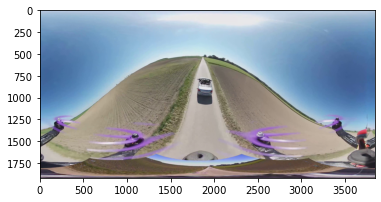

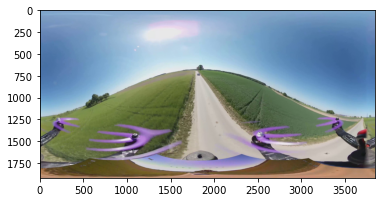

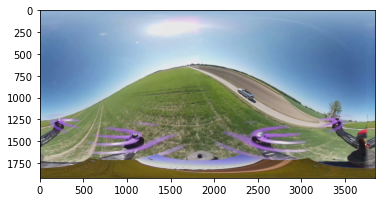

In [7]:
# prints out a random selection of 3 images
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

**If you want to retrain after changing the image processing logic, no need to run the cells above; start from this one.**

In [8]:
#Lets declare our image dimensions
#we are using coloured images. 
nrows = 500
ncolumns = 250
channels = 6 # change to 1 if you want to use grayscale image
import copy
import json

#A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    # salient_points = json.loads(open("../input/salientvr24/24_train/data.txt", 'r').read())
    index = 0
    for image in list_of_images:
        resized_img = cv2.cvtColor(cv2.resize(cv2.imread(image), (nrows, ncolumns), interpolation=cv2.INTER_CUBIC), cv2.COLOR_BGR2RGB)
        cannyed = cv2.Canny(resized_img, 200, 225)
        cannyed2 = cv2.Canny(resized_img, 150, 275)
        
        im1 = np.array(resized_img)
        im2 = np.array(cannyed)
        im3 = np.array(cannyed2)
        
        im4 = np.zeros_like(im2)
        gray = cv2.cvtColor(resized_img,cv2.COLOR_RGB2GRAY)
        corners = cv2.goodFeaturesToTrack(gray,20,0.1,50)
        corners = np.int0(corners)
        for i in corners:
            xx,yy = i.ravel()
            cv2.circle(im4, (xx, yy), 15, (255, 255, 255), -1, 8, shift=0)
            
#         im7 = np.zeros_like(im5)
#         for circle in salient_points[index]["salient"]:
#             cv2.circle(im7, (int(circle[0] / 3840 * 500), int(circle[1] / 1920 * 250)), 20, (255, 255, 255), -1, 8, shift=0)
        #
        combined = np.dstack((im1, im2, im3, im4))
        # print(f"1: {im1.shape}, 2: {im2.shape}, combined: {combined.shape}")
        
        image_id = int(image.split("/")[-1].split(".")[0][5:])
        for i in range(image_id, image_id + 30):
            X.append(combined)
            image_url = f"frame{i}.jpg"
            if image_url not in centroids:
                break
            cent = copy.deepcopy(centroids[image_url])
            if i == 0:
                print(cent)
            for i2 in range(len(cent)):
                if i2 % 2 == 0:
                    cent[i2] = cent[i2] / 3840 * nrows
                else:
                    cent[i2] = cent[i2] / 1920 * ncolumns
            if i == 0:
                print(cent)
            y.append(cent)
        index += 1
    newX = X #np.expand_dims(X, axis=3) # X
    return X, np.array(newX), np.array(y)

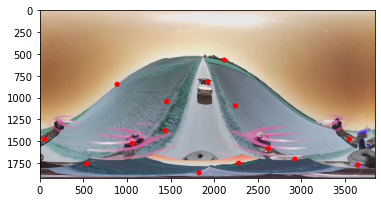

(<matplotlib.image.AxesImage at 0x7f04028cb650>, None)

In [9]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread(train_imgs[0])
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

corners = cv2.goodFeaturesToTrack(gray,15,0.1,300)
corners = np.int0(corners)
# print(corners)
for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),30,255,-1)

plt.imshow(img),plt.show()

In [10]:
# reads in all the images and process them
vX, X, y = read_and_process_image(train_imgs)
print(X.shape)

(1800, 250, 500, 6)


[240.17031989 123.31791437  91.7713132  139.60416193 499.24040487
  48.89094559]
[360.46455403  97.13261235 147.35105123 134.69546377 240.38882613
 128.68427771]
[147.5515226  134.65515156 346.2054426  102.27356688 237.66861432
 128.87606377]
[235.2915436  128.50303432 139.37333199 137.03217903 345.57749713
 102.07957768]
[344.94944895 101.96780823 235.30346789 128.4454141  139.8379941
 136.97337682]


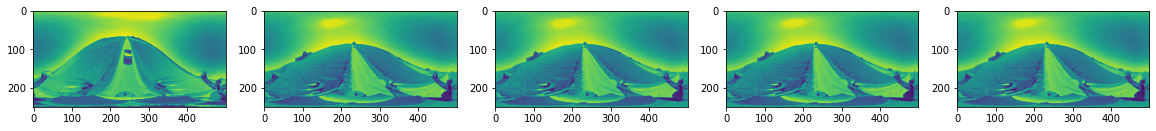

In [11]:
#Lets view some of the pics
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(vX[-i][:, :, 1])
    print(y[-i])


In [12]:
# train: (# rows, height, width, layer (1 for canny/gray, 3 for rgb))
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (1800, 250, 500, 6)
Shape of labels is: (1800, 6)


In [13]:
#Lets split the data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (1440, 250, 500, 6)
Shape of validation images is: (360, 250, 500, 6)
Shape of labels is: (1440, 6)
Shape of labels is: (360, 6)


In [14]:
#clear memory
del X
del y
gc.collect()


#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)
# print(X_train)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32 


Now lets create our model.

In [15]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(nrows, ncolumns, channels))) # add in 3 in input_shape for normal img
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  #Dropout for regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(clusters * 2))  #Sigmoid function at the end because we have just two classes

In [46]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential # to create a cnn model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (nrows, ncolumns, channels)))
model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.25))

# fully connected
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(clusters * 2))

In [36]:
# best

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential # to create a cnn model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (6,6), padding = 'Same', activation = 'relu', input_shape = (nrows, ncolumns, channels)))
# model.add(Conv2D(filters = 32, kernel_size = (6,6), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
# model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
# model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
# model.add(Dropout(0.25))

# fully connected
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.4))
# model.add(BatchNormalization())
model.add(Dense(clusters * 2))

In [47]:
#Lets see our model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 500, 250, 16)      2416      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 500, 250, 16)      6416      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 250, 125, 16)      0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 250, 125, 16)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 250, 125, 32)      4640      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 250, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 125, 62, 32)      

In [48]:
# custom loss function (sort points by x then y)
from keras import losses
import tensorflow as tf
from keras.optimizers import Adam

def sort_points(y):
    re_y = tf.reshape(y, [-1, 2])
    sorted_y = tf.sort(y,axis=0,direction='ASCENDING',name=None)
    return sorted_y

def chain(two_dim):
    return list(itertools.chain(*two_dim))

THRESHOLD = 0
mse = losses.MeanSquaredError()
def custom_mse(y_true, y_pred):
    sorted_true = sort_points(y_true)
    sorted_pred = sort_points(y_pred)
    viewport_mse = mse(sorted_true, sorted_pred)
    if viewport_mse <= THRESHOLD:
        viewport_mse = 0.0
    return viewport_mse

In [55]:
model.compile(loss=custom_mse, optimizer=Adam(learning_rate=0.001)) # 0.001
model.fit(X_train,y_train,epochs=8, validation_data=(X_val, y_val))

Epoch 1/8
45/45 [==============================] - 6s 128ms/step - loss: 921.9499 - val_loss: 1599.6097
Epoch 2/8
45/45 [==============================] - 5s 120ms/step - loss: 925.2822 - val_loss: 1285.0334
Epoch 3/8
45/45 [==============================] - 5s 116ms/step - loss: 1029.9274 - val_loss: 1243.2809
Epoch 4/8
45/45 [==============================] - 5s 116ms/step - loss: 980.7372 - val_loss: 1320.9880
Epoch 5/8
45/45 [==============================] - 5s 116ms/step - loss: 897.7806 - val_loss: 1294.9398
Epoch 6/8
45/45 [==============================] - 5s 117ms/step - loss: 850.3458 - val_loss: 2412.6709
Epoch 7/8
45/45 [==============================] - 5s 116ms/step - loss: 955.4597 - val_loss: 1379.8519
Epoch 8/8
45/45 [==============================] - 5s 117ms/step - loss: 889.5359 - val_loss: 1679.1826


0: 756.58935546875
1: 503.3838806152344
2: 604.3742065429688
3: 749.4103393554688
4: 315.1475524902344
5: 321.2257080078125


ValueError: num must be 1 <= num <= 6, not 7

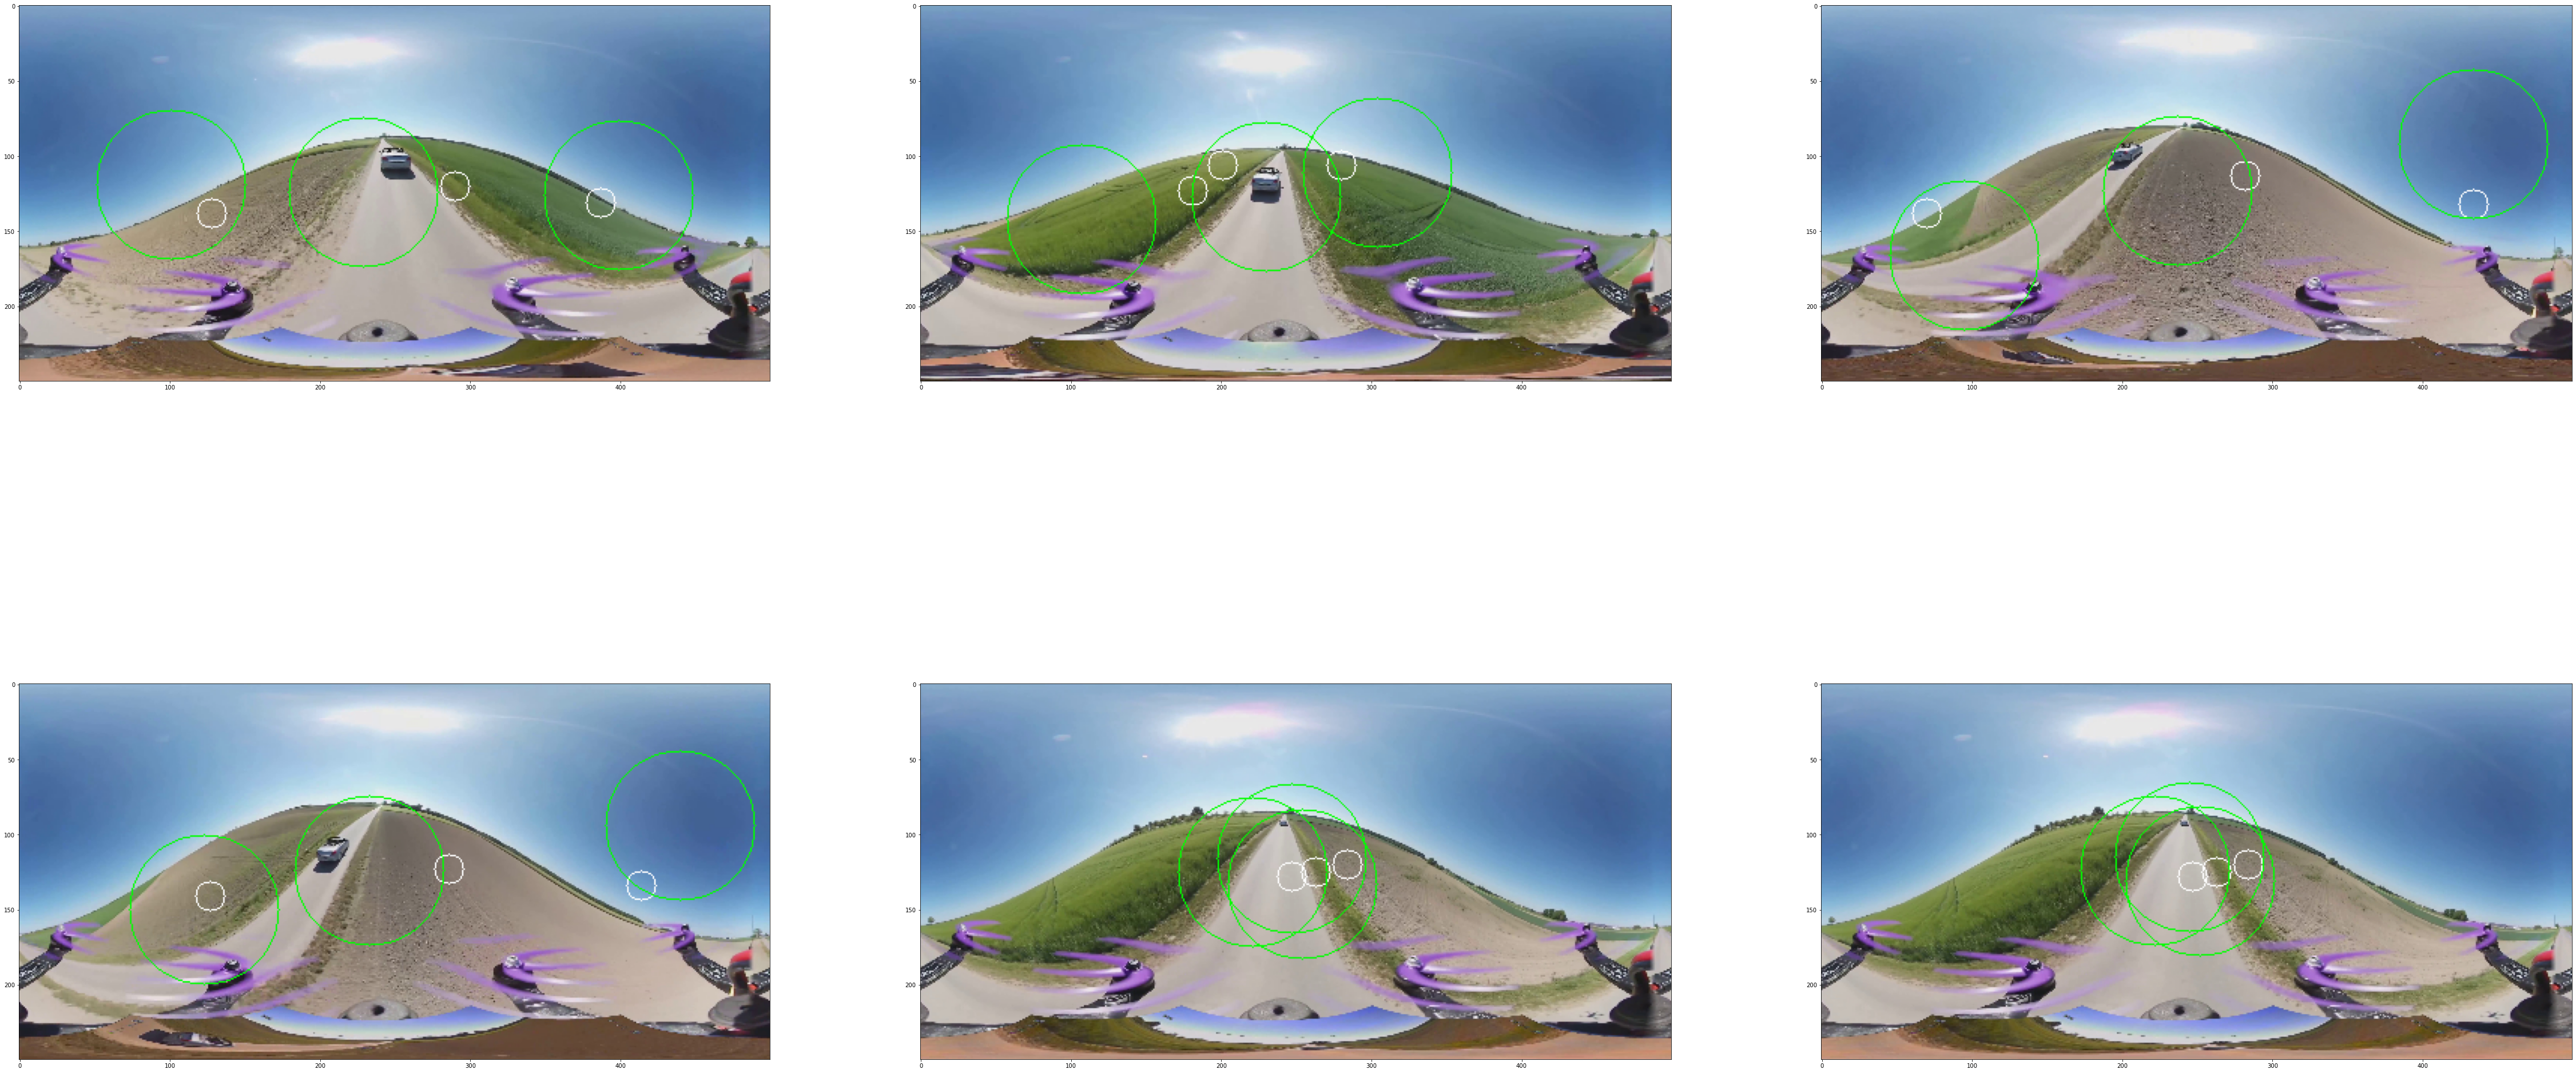

In [66]:
# predY=model.predict(np.array(X_test))
# predY=np.round(predY).astype(int).reshape(1,-1)[0]
predict = model.predict(X_val)
# print(predict)
plt.figure(figsize=(80,40))
columns = 3
i = 0
count = 0
for val_image in X_val:
    new_image = np.array(val_image[:, :, :3], copy=True)
    loss = custom_mse(y_val[i], predict[i])
    if loss < 900:
        for j in range(0, len(predict[i]), 2):
            cv2.circle(new_image, (predict[i][j], predict[i][j+1]), 10, (255, 255, 255), lineType=8, shift=0)
        for j in range(0, len(y_val[i]), 2):
            cv2.circle(new_image, (int(y_val[i][j]), int(y_val[i][j+1])), 50, (0, 255, 0), lineType=8, shift=0)
        plt.subplot(5 / columns + 1, columns, count + 1)
        print(f"{count}: {loss}")
        count += 1
        plt.imshow(new_image)
    if count == 6:
        break
    
    i += 1

median: 3755.58837890625, iqr: 1735.2211151123047


(array([115., 140.,  67.,  22.,   7.,   1.,   4.,   1.,   0.,   3.]),
 array([  109.01931,  2668.4282 ,  5227.837  ,  7787.2456 , 10346.654  ,
        12906.063  , 15465.473  , 18024.88   , 20584.29   , 23143.7    ,
        25703.107  ], dtype=float32),
 <a list of 10 Patch objects>)

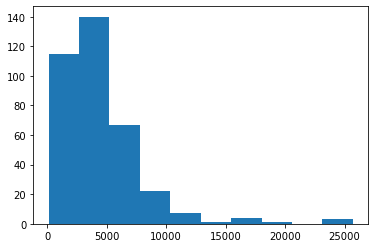

In [56]:
import statistics

losses = []
i = 0
for val_image in X_val:
    loss = custom_mse(y_val[i], predict[i])
    losses.append(loss)
    i += 1
median = np.median(np.array(losses), axis=0)
iqr = np.subtract(*np.percentile(np.array(losses), [75, 25])) / 2
print(f"median: {median}, iqr: {iqr}")

import matplotlib.pyplot as plt
plt.hist(losses, bins=10)

In [63]:
count = 0
for loss in losses:
    if loss < 60 ** 2:
        count += 1
print(count / len(losses))

0.48055555555555557


In [23]:
print(X_val[0].shape)

(250, 500, 6)


In [54]:
#Save the model
model.save_weights('model_weights_sorted_3_vp_final.h5')
model.save('model_keras_sorted_3_vp_final.h5')